In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import scipy
import pickle

In [2]:
sys.path.append('../../source/')
sys.path.append('../Tang/')
from JungeUtilities import beta_hedging, portfolio_ize, date_to_int
from get_beta import get_beta
from energy_functions import correlation, sharpe, volatility
from Hedge import Hedge

In [59]:
def swap(market_symbols, year_symbols):
    """
    Randomly changes the symbols in a market. Can either grow or shrink the market by 1 asset.  
    
    Inputs:
    -------
    market_symbols: list of symbols that are in a market
    year_symbols:   list of all the possible symbols for a given year
    
    Output:
    -------
    symbols: list of symbols in the market after the random change.  
    
    """
    coin_flip = np.random.binomial(1, 0.5)
    
    if (coin_flip == 0) and len(market_symbols)>10: # Shrink the market by one asset
        
        # Pick a random list index and pop that symbol off
        market_symbols.pop(np.random.randint(len(market_symbols)))
        return market_symbols
    
    else: # Grow the market by one asset
        
        # Get a list of the symbols for that year that are not already in the portfolio
        potential_symbols = list(set(year_symbols) - set(market_symbols))
        symbol_to_add = np.random.choice(potential_symbols)
        market_symbols.append(symbol_to_add)
        return market_symbols

In [80]:
def simulated_annealing(hedge, init_temp, min_temp, cool_by, reanneal, num_iter, energy_func):
    """
    Inputs:
    -------
    hedge: 
        hedge object that already has an instantiated market and portfolio. 
    init_temp: 
        float that controls the initial temperature of the algorithm
    min_temp: 
        float that acts as a floor for the decreasing temperature.  When this is hit, we heat back up to init_temp.  
    cool_by: 
        float that controls the speed that the cooling occurs
    reanneal: 
        integer that controls how many iterations pass between cooling steps
    num_iter: 
        integer that controls the total number of iterations that the algorithm runs
    energy_func:
        function that determines the energy state, eg correlation, volatility, sharpe ratio
    
    Returns:
    --------
    states: 
        a history of the current energy state at each iteration
    best_market: 
        list of the symbols for the best hedging market found
    """

    
#     hedge.generateRandomMarket()
    
    portfolio_values = hedge.dollar_portfolio_sum
    portfolio_returns = hedge.dollar_portfolio_sum_ret
    
    market = list(hedge.market)
    market_values = hedge.dollar_market_sum
    market_returns = hedge.dollar_market_sum_ret
    
    spy_returns = hedge.spy.pct_change()[61:]
    
    # Get betas from portfolio returns and market returns.
    _, betas = get_beta(portfolio_returns, market_returns)
    
    # Perform beta hedging.
    hedged_returns = beta_hedging(pd.Series(betas, index=market_values[60:].index),\
                                  market_values[60:], portfolio_values[60:])
    hedged_returns = hedged_returns.values.reshape(hedged_returns.shape[0])

        
    # A running account of the best market found.  This is updated as better markets are found.       
    best_market_energy = energy_func(hedged_returns[1:], spy_returns[1:])
    best_market = hedge.market
    
    # Initial value for old_E is the initial total value of the starting point.
    old_E = best_market_energy
    
    temperature = init_temp
    
    # A history of the current state of the algorithm.
    states = np.zeros(num_iter)
    
    for i in range(num_iter):
        if i%10==0:
            print i
        
        # Switch the bag up a little bit and recalculate market values and returns.  
        market = list(hedge.market)
        hedge.market = swap(market, hedge.stockuniverse)
        
        market_values = hedge.dollar_market_sum
        market_returns = hedge.dollar_market_sum_ret
            
        # Get beta values from portfolio and market.
        _, betas = get_beta(portfolio_returns, market_returns)
        
        # Perform beta hedging.
        hedged_returns = beta_hedging(pd.Series(betas, index=market_values[60:].index), \
                                          market_values[60:], portfolio_values[60:])
        hedged_returns = hedged_returns.values.reshape(hedged_returns.shape[0])

        # Examine energy state of the new bag.
        new_E = energy_func(hedged_returns[1:], spy_returns[1:])
        
        delta_E = new_E - old_E
        
        # We always accept an improvement.
        if new_E < old_E:
            #market = proposed_market
            states[i] = new_E
            old_E = new_E
            # Update our running best bag found.
            if new_E > best_market_energy:
                best_market_energy = new_E
                best_market = market
        # We sometimes accept a decline because this can get us out of a local minimum.
        elif np.random.rand() < np.exp(-delta_E / temperature):
            #market = proposed_proposed
            states[i] = new_E
            old_E = new_E

        # And sometimes we just stay where we are until something better comes along.
        else: 
            states[i] = old_E
            # Put the old market back in
            hedge.market = market
            
        # Cool down slowly at the defined interval.
        if num_iter % reanneal == 0:
            temperature = temperature * cool_by
            
            # Reheat when the temperature gets too cold.
            if temperature < min_temp:
                temperature = init_temp
    
    hedge.market = best_market
    return accepted, states, best_market

In [132]:
hedge.generateRandomPort()

array(['FLIR', 'IVC', 'KNDI', 'MHO', 'EVC', 'PCO', 'COWN', 'NILE', 'MIW',
       'ANAC', 'ADHD', 'PLBC', 'ESXB', 'JRO', 'WES', 'HURC', 'MQT', 'EROS',
       'RPAI', 'HMNF'], dtype=object)

In [133]:
hedge = Hedge(begindate='2014-01-01', enddate='2014-12-31')
hedge.portfolio = ['FLIR', 'IVC', 'KNDI', 'MHO', 'EVC', 'PCO', 'COWN', 'NILE', 'MIW',
       'ANAC', 'ADHD', 'PLBC', 'ESXB', 'JRO', 'WES', 'HURC', 'MQT', 'EROS',
       'RPAI', 'HMNF']
hedge.market = ['GPX', 'GRMN', 'MPWR', 'ENR', 'CTHR', 'PRFZ', 'SUMR', 'CUBE',
       'ACTS', 'ANF', 'MYI', 'SON', 'SSL', 'PW', 'KT', 'TWN', 'IPWR',
       'AAN', 'CASH', 'DISCA', 'RFP', 'HPS', 'WMB', 'VRSN', 'ETN', 'WPZ',
       'RAI', 'BOXC', 'ARCI', 'EMN', 'LMOS', 'EXPD', 'NQS', 'GB', 'KNOP',
       'CNL', 'ENDP', 'SPSC', 'SCVL', 'EPAY']


ac, st, bm = simulated_annealing(hedge, init_temp=1, min_temp=0.01, cool_by=0.99, reanneal=100, num_iter=10000, \
                    energy_func=sharpe)
print ac, "Accepted"

0
10
20
30
40
50
60
70
80
90
50 Accepted


In [134]:
print "Number of assets in market at the end:", len(hedge.market)

Number of assets in market at the end: 26


TypeError: ylabel() takes at least 1 argument (0 given)

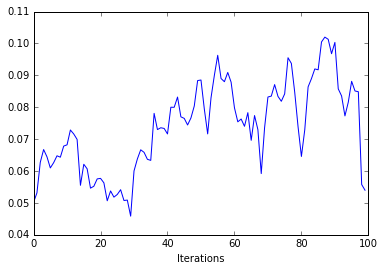

In [138]:
plt.plot(-st)
plt.xlabel("Iterations")
plt.ylabel()

## Results

In [136]:
_,betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.dollar_market_sum_ret)

hedged_returns_dollars = beta_hedging(pd.Series(betas, index=hedge.dollar_market_sum[60:].index), \
                                          hedge.dollar_market_sum[60:], hedge.dollar_portfolio_sum[60:])
hedged_returns_dollars = hedged_returns_dollars.values.reshape(hedged_returns_dollars.shape[0])

p = hedged_returns_dollars[1:]
m = hedge.spy.pct_change()[61:][1:]
print "Absolute Value of Correlation with S&P:", correlation(p,m)
print "Volatility:", volatility(p,m)
print "Sharpe Ratio:", -sharpe(p,m)
print "Relative Return:", 100*(np.sum(hedged_returns_dollars[1:])/1000.), "%"
print "S&P Return", (hedge.spy[-1]-hedge.spy[0])/hedge.spy[0]*100, "%"

Absolute Value of Correlation with S&P: 0.317885530057
Volatility: 6.7842260825
Sharpe Ratio: 0.05398013245
Relative Return: 6.95805502758 %
S&P Return 12.3865939845 %


## Baseline

In [137]:
_,betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.spy)

hedged_returns_dollars = beta_hedging(pd.Series(betas, index=hedge.dollar_market_sum[60:].index), \
                                          hedge.spy[60:], hedge.dollar_portfolio_sum[60:])
hedged_returns_dollars = hedged_returns_dollars.values.reshape(hedged_returns_dollars.shape[0])

p = hedged_returns_dollars[1:]
m = hedge.spy.pct_change()[61:][1:]
print "Absolute Value of Correlation with S&P:", correlation(p,m)
print "Volatility:", volatility(p,m)
print "Sharpe Ratio:", -sharpe(p,m)
print "Relative Return:", 100*(np.sum(hedged_returns_dollars[1:])/1000.), "%"
print "S&P Return", (hedge.spy[-1]-hedge.spy[0])/hedge.spy[0]*100, "%"

Absolute Value of Correlation with S&P: 0.673705647743
Volatility: 10.0105301549
Sharpe Ratio: 0.0278680503298
Relative Return: 5.3005052055 %
S&P Return 12.3865939845 %
